### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'PMG 287 monitoring'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_1000/all.csv',
                'Silane': '../data/silan/pmg166_3rdseries_full.csv',
                'PMG 247 monitoring': '../data/PMG_247/preprocessed_PMG247_monitoring.csv',
                'PMG 271 monitoring': '../data/PMG_271/PMG271_monitoring_druga_seria.csv',
                'PMG 284 monitoring': '../data/PMG_284/seria1.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_1000/sucrose.csv', 
                                            '../data/saccharose_1000/glucose.csv',
                                            '../data/saccharose_1000/fructose.csv'],
                'Silane': [],
                'PMG 247 monitoring': ['../data/PMG_247/preprocessed_substrate0.csv',
                                      '../data/PMG_247/preprocessed_substrate1.csv'],
                'PMG 271 monitoring': ['../data/PMG_271/preprocessed_substrate0.csv',
                                      '../data/PMG_271/preprocessed_substrate1.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_substrate0.csv',
                                      '../data/PMG_284/preprocessed_substrate1.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_substrate0.csv',
                                      '../data/PMG_287/preprocessed_substrate1.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': ',',
                'PMG 271 monitoring': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': '\t',
                'PMG 271 monitoring': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_1000/comparing_with_first/known_substrats/',
                'Silane': '../results/silan/comparing_with_first/known_substrats/',
                'PMG 247 monitoring': '../results/PMG_247/comparing_with_first/known_substrats/',
                'PMG 271 monitoring': '../results/PMG_271/comparing_with_first/known_substrats/',
                'PMG 284 monitoring': '../results/PMG_284/comparing_with_first/known_substrats/',
                'PMG 287 monitoring': '../results/PMG_287/comparing_with_first/known_substrats/'}

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    mixture_time_data = mixture_time_data.iloc[:,:-1]
elif experiment_name == 'PMG 271 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_20th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::20]
    mixture_time_data = pd.concat((ppm, every_20th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [9]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [10]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [11]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


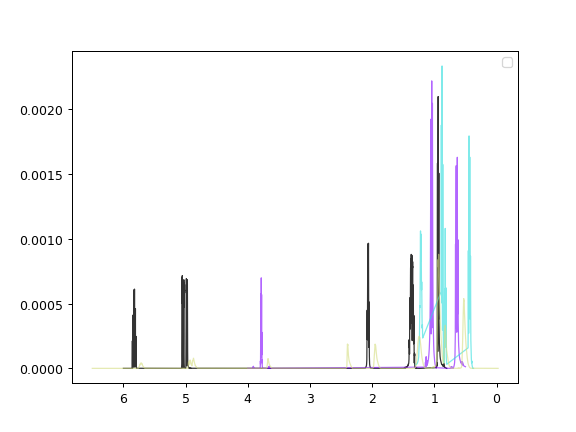

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [13]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 1)], profile=True)

### Estimation

In [14]:
kappa = 1
kappa_th = 0.1

In [15]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
    if i>1:
        assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.43632067264599866, 0.21551089009799934, 0.34816843725599894]


Proportion_of_noise_in_components:

0.3730110954709988


This is timepoint 2.

Proportions:

[0.36337131980999987, 0.2661558734989999, 0.3704728066909999]


Proportion_of_noise_in_components:

0.42428871092799986


This is timepoint 3.

Proportions:

[0.36019871815600035, 0.2746928563080002, 0.3651084255360003]


Proportion_of_noise_in_components:

0.4213812450050004


This is timepoint 4.

Proportions:

[0.3603054604920011, 0.26862069233900077, 0.37107384716900105]


Proportion_of_noise_in_components:

0.41912374144600123


This is timepoint 5.

Proportions:

[0.3617231562419999, 0.27002789711699987, 0.3682489466409999]


Proportion_of_noise_in_components:

0.41809031428599985


This is timepoint 6.

Proportions:

[0.36188207695899793, 0.27156704638299844, 0.36655087665799796]


Proportion_of_noise_in_components:

0.4165521031449977


This is timepoint 7.

Proportions:

[0.36529960586800103, 0.272817172720

Proportions:

[0.14352240483200016, 0.10887728824600013, 0.7476003069220007]


Proportion_of_noise_in_components:

0.11999953101600014


This is timepoint 54.

Proportions:

[0.13944949512400037, 0.10319913288700028, 0.757351371989002]


Proportion_of_noise_in_components:

0.11191114988600029


This is timepoint 55.

Proportions:

[0.13456988530400033, 0.09738926622000024, 0.7680408484760018]


Proportion_of_noise_in_components:

0.10448381768700025


This is timepoint 56.

Proportions:

[0.1335017998929996, 0.09266240279999971, 0.7738357973069976]


Proportion_of_noise_in_components:

0.10233177832399969


This is timepoint 57.

Proportions:

[0.12857501733700008, 0.08827805734600006, 0.7831469253170006]


Proportion_of_noise_in_components:

0.10006595618100007


This is timepoint 58.

Proportions:

[0.1293906515429999, 0.08479279532499993, 0.7858165531319994]


Proportion_of_noise_in_components:

0.08903614852299993


This is timepoint 59.

Proportions:

[0.12772922517100055, 0.08137

In [16]:
len(proportions_in_times)

100

<IPython.core.display.Javascript object>


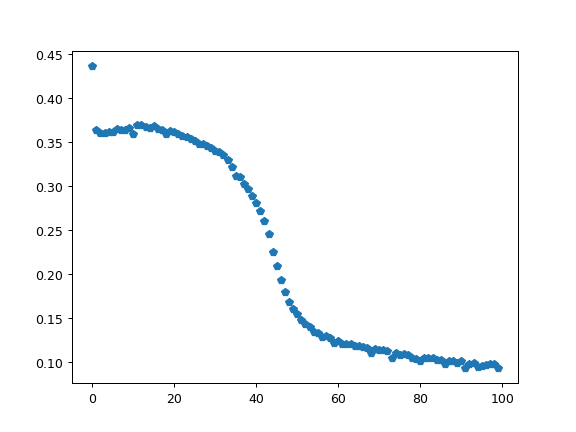

In [19]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')

In [20]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [21]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [22]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [23]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [24]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)

### Linear regression

In [34]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [35]:
t = np.array(range(1, y.shape[0]+1))
t_and_ones = np.vstack([t, np.ones(len(t))]).T

In [36]:
reagent_number = 1

In [37]:
slope, intercept = np.linalg.lstsq(t_and_ones, y)[0][:,reagent_number]

/tmp/ipykernel_5844/1931212556.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0][:,reagent_number]


<IPython.core.display.Javascript object>


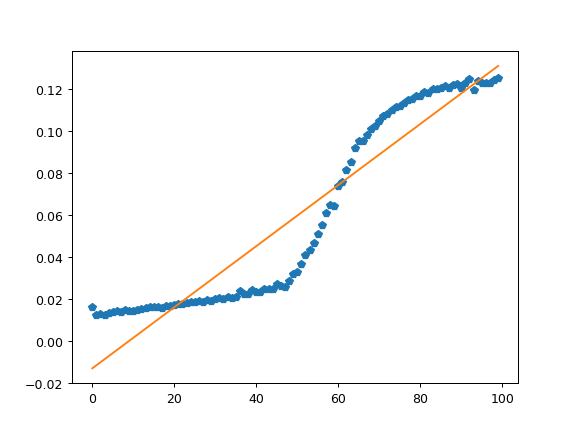

In [38]:
plt.plot(range(len(y)), [prop[reagent_number] for prop in y], 'p')
plt.plot(slope*t+intercept)